<a href="https://colab.research.google.com/github/Khajavax/mdh22/blob/main/mdanalysis_colab_Step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Welcome to the world of Molecular Dynamics! This lesson is to teach you the basic protocol of analyzing a molecular dynamics (MD) simulation, including a bit of Python coding. If you don't know how to code, don't worry! These lessons assume no prior knowledge of code or Python.

If you have not completed Step 1 and would like to do so, click this link: https://colab.research.google.com/drive/1vKxP4MJhdIODzScluSeU73NHOWwJIPn8?usp=sharing

## Analyzing molecular dynamics
MD simulates the motion of molecules and can describe how the structure changes over time. The analysis of molecular dynamics extracts properties from the "movie" of the molecule such as how mobile areas of the molecule were and how the pKa values of certain functional groups can vary as the molecule moves. This information can help describe the mechanism of action as conformational changes in enzymes are linked to catalytic activity and pKa is related to nucleophilicty.

## What will I get from this Colab?
The first steps of the colab show whether the molecule reached equilibrium during the simulation, which indicates how reliable or confidently you can interpret the rest of the values. The second section of the Colab describes which areas of the molecule are most dynamic. Finally, the code will calculate the pKa values for each frame of the simulation to show pKa values over time. These values and outputs can be compared to simulations of mutants or the protein with ligands to determine how these changes to the simulation environment alter the dynamics of the molecule.

[Guide video for using this colab](https://www.loom.com/share/cb783e87ba294bee916d0fd1e0847fee?sid=ac7a0852-00c7-4cc9-b2b1-cd142ee9b7fc)



---




####**Please make a copy of this colab for your personal use!!**

A few things to start:

1.   These lessons only work in Google Chrome
2.   If you want to save your progress, go to File> Save a Copy in Drive; then locate a spot in your Drive folder
3.   Clicking the "play" button to the top left of a code block runs the code. Sometimes you can see the code and interact with it. However, if the code is hidden  it is to run adminstrative tasks in the background and you do not need to worry unless you are interested.
4. Sometimes the code may be hidden from view. To view it, click the '>' on the left of the title, until it changes to 'v'. This will reveal the code in that line.

Here are the files you will need for this code to run:
*   **.dcd** is a file format that store simulation trajectories. Simulation trajectories are a dynamic view of various properties in your protein, including atom coordinates, box size, velocities, and forces. Trajectory files looks at these variables as they change throughout time. You should have this file from your MD run in step 1.
*  A .pdb file containing a set of atomic coordinates of your molecule. **.pdb** stands for a Protein Data Bank file. It is a file containing the three-dimensional structural data of your protein directly from the Protein Data Bank. If you run into errors with your PDB file, ask your instructor. You should have this file from your MD run in step 1.

If you want to remove waters from your files (you may want this if you did not use the Step 1 colab), you will need a .prmtop file:
*  **.prmtop** is the topology of your protein. Toplogy means how the atoms connect together and the location of each atom. You should have this file from Step 1.

If you would like a tutorial on Python basics, please reference [this colab](https://colab.research.google.com/drive/1UVupXh23ArJp2F9vqTmkVh0JnjEaemi1?usp=sharing ). It is not necessary to do this, however if you are interested in learning more about coding it is a great resource to use!

This should take approximately 30 minutes to run.

---

**Acknowledgments**
- Colab developed by **Angela Kayll, Angelina Sardelli, and Christopher Berndsen** at James Madison University (ver 1 2024) with input and feedback from students in CHEM260 and members of the [MCC community](https://www.mdhcures.org/).


In [1]:
#@title **1a. Install Conda Colab**
#@markdown Press PLAY. It will restart the kernel (session), don't worry. But do not start
#@markdown any other cells until this one finishes!
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [2]:
#@title **1b. Install and load dependencies**
#@markdown Press PLAY **after** the above cell has completed and the session restarted.
#@markdown This will take a few minutes.
!pip install -q mdtraj
!pip install -q matplotlib
!pip install --upgrade MDAnalysis --quiet
!pip install -q pandas
!pip install -q seaborn
!pip install -q propkatraj

import pandas as pd
import mdtraj as md
import matplotlib.pyplot as pp
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align, diffusionmap
import seaborn as sns
from propkatraj import PropkaTraj

Once both of the above have run, *then* you can begin analyzing the trajectory.

1.   Click on the file folder on the left side
2.   **Right-click**, bring up the actions menu, and create a folder. Name this folder "data".
3. Upload the .dcd file and the .pdb file. Put these files in the "data" folder. The .dcd files are often large so be patient.
4.   **Right-click**, bring up the actions menu, and create a folder. Name this folder "outputs". This is where we will put any output files or figures. **Remember to download all of these files when done.**
5.  I'll provide instructions on the basic commands and analyses, if you add more remember to save what you are doing.




##If you do not need to remove waters, then proceed with the steps below!

# Removing waters
Unless you are specifically interested in the waters (and they often are interesting to look at), they are generally removed from the files. This helps reduce the file size and keeping track of all the components of the simulation. The Step 1 colab typically removes the waters automatically, however, **if you are bring a file from a different source OR chose not to remove the waters and need to, there is code at the very bottom which allows you to do this.**

**If you do not need to remove waters, then proceed with the steps below**



---

## 1c Load the data
Change the filenames to match the names of the uploaded files. Remember to wait until the uploads have completed before running this box.

In [3]:

# these are the names of your files, replace the "xxx" with your file name
dcd = 'inputs/traj.dcd'
pdb = "inputs/modelmimic.pdb"
u = mda.Universe(pdb, dcd)

/usr/local/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


# Analysis of the trajectory
We will use the MDAnalysis package to do the analysis and Matplotlib to plot our results. In the first step we will load the no solvent trajectory file that we made previously and use the pdb file from above to define the system.

---
## 2. RMSD analysis

For the **first box**, it will load your .dcd and .pdb files. Change the file names in the area labeled "xxx" to the names of your files.

For the **second box**, it will calculate your root mean square deviation (RMSD), which will indicate how much your trajectory changed from the start to the end of your simulation. You do not need to edit anything in this box unless your instructor tells you to.

For the **third box**, it will make a pretty visualization of your RMSD results and save it as a CSV file. It will also show you the first five rows of data to allow you to assess the quality of the output. You do not need to edit anything in this box unless your instructor tells you to.

For the **fourth box**, it will plot your data as a png file. The RMSD plot gives a sense of whether the protein has reached a fixed state over the simulation, but it is not particularly good at comparing the structures overall. You do not need to edit anything in this box unless your instructor tells you to.

In [4]:
# calculate rmsd
# RMSD = root mean square deviation, and indicates how much the trajectory changed from start to end
u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein']) # select the areas to analyze, in this case the protein backbone atoms
rmsd_analysis.run(); # run the analysis

In [5]:
# make a pretty data frame using pandas
rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd[:, 1:],
                       columns=['time', 'Backbone', 'C-alphas', 'Protein'])

# save this information as a CSV file
rmsd_df.to_csv('outputs/RMSD_df.csv')

# show the first five rows to make sure it looks right
rmsd_df.head()

,time,Backbone,C-alphas,Protein
0,0.0,0.000001,4.168798e-07,4.212935e-07
1,1.0,0.665520,6.369054e-01,9.475185e-01
2,2.0,0.763091,7.473108e-01,1.065827e+00
3,3.0,0.806496,7.951183e-01,1.139872e+00
4,4.0,0.849115,8.299691e-01,1.180747e+00


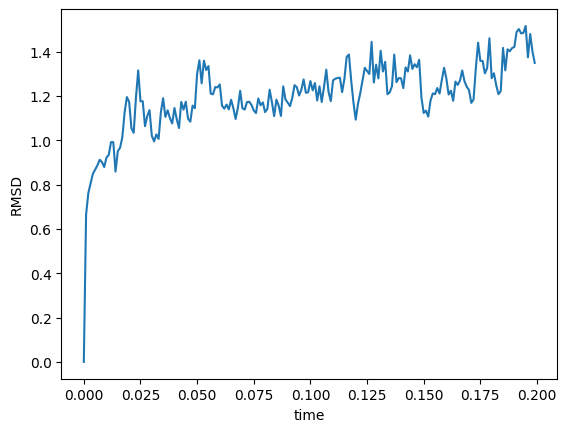

In [6]:
# show the data in frame (you can change the axes values as needed)
fig, ax = pp.subplots()
ax.plot(rmsd_df['time']/1000, rmsd_df['Backbone'])
ax.set(xlabel = 'time', ylabel = 'RMSD')

# save the plot
pp.savefig('outputs/rmsd_plot.png')

The RMSD plot above gives a sense of whether the protein has reached a fixed state over the simulation but is not particularly good at comparing the structures overall. The code below will do a pairwise comparison of all the frames and show the data as a heatmap to suggest if there are conformational changes that appear consistently in your protein. A heatmap is a 2D data visualization technique that shows a visual summary of data across two axis. Consistent conformational changes could suggest a specific function within your protein, as structure = function!



---
## 3. Pairwise RMSD plot


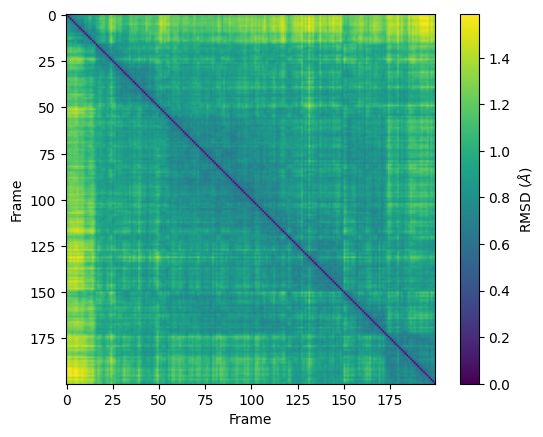

In [7]:
# align the trajectory to itself pairwise
aligner = align.AlignTraj(u, u, select='name CA',
                          in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(u, select='name CA').run()

# plot the pairwise alignment as a distribution
pp.imshow(matrix.results.dist_matrix, cmap='viridis')
pp.xlabel('Frame')
pp.ylabel('Frame')
pp.colorbar(label=r'RMSD ($\AA$)');
pp.savefig('outputs/rmsd_compare_plot.png')



---
## 4. Root Mean Square Flucuation plot

The code below will calculate the root mean square fluctuation, effectively how much motion each amino acid has during the simulation. It is similar to RMSD, except instead of looking at positional differences in the entire structure over time, it will specify the movement/fluctuation of each residue during a simulation.



---



/usr/local/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:904: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


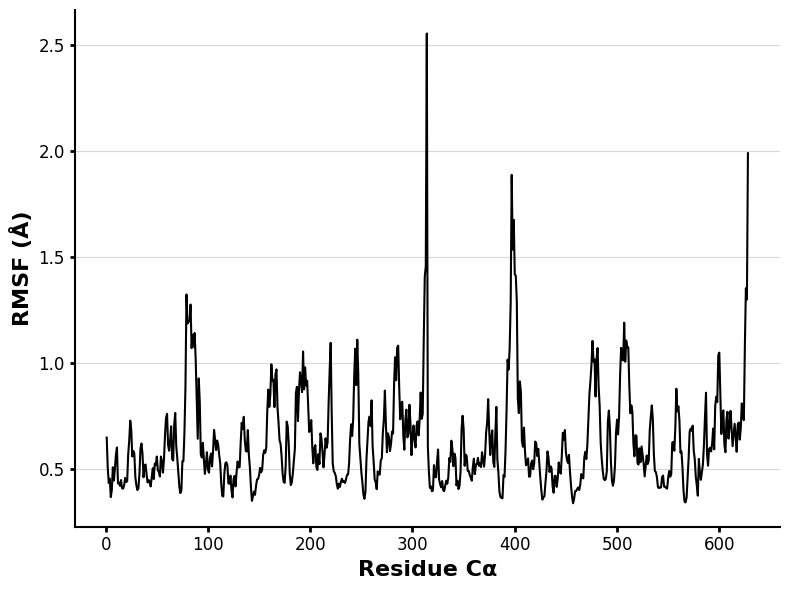

In [8]:
# calculate the root mean square flucuation, effectively how much motion each amino acid has during the simulation
calphas = u.select_atoms("name CA") #Commonly the RMSD is computed using the aC of the protein to evaluate protein flucturation respecting the initial coordinates
rmsfer = rms.RMSF(calphas,verbose=False).run()
RMSF_table=pd.DataFrame(rmsfer.rmsf,index=calphas.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue
# save the data
RMSF_table.to_csv("outputs/RMSF_df.csv")

# make the plot
pp.rcParams['axes.linewidth'] = 1.5
fig, ax = pp.subplots(figsize=(8,6))

pp.plot(calphas.resnums, rmsfer.rmsf,linewidth=1.5,color='k')

pp.xlabel ('Residue Cα',fontsize=16,fontweight='bold')
pp.ylabel ('RMSF (Å)',fontsize=16,fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pp.tick_params ('both',width=2,labelsize=12)
pp.grid (axis='y',alpha=0.5)
pp.tight_layout()
pp.savefig('outputs/rmsf_plot.png')
pp.show()
# save the plot


## 5. Predict pKa values
This takes a bit of time (20+ minutes). Produces a spreadsheet of pKa at each step in the trajectory for each amino acid side chain that typically ionizes under biological conditions. The amino acids are indicated by residue number in the protein, so it may not exactly match the sequence numbering if the simulation uses a distinct numbering scheme.
The describe cell gives a summary of the trajectory, while the to csv cell saves the entire set of data for plotting.

**Make sure to only press PLAY once the previous run is complete!!**

In [9]:
pkatraj = PropkaTraj(u, select='protein', skip_failure=False)
pkatraj.run()

/usr/local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [10]:
pkatraj.results.pkas.describe()

,1,2,21,28,32,33,36,43,46,48,...,608,612,614,618,619,621,622,625,628,628
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,7.345783,10.429922,8.236299,12.716260,11.638648,4.331576,6.305341,2.529507,4.533856,4.909490,...,2.876143,4.011100,11.362427,11.433927,10.840208,5.195531,2.548222,10.932699,10.445608,2.536034
std,0.252336,0.205143,0.134654,0.226291,0.150747,0.360114,0.051222,0.582381,0.800056,0.479234,...,0.247736,0.611563,0.337785,0.149148,0.339880,0.430889,0.468264,0.500355,0.053682,0.464434
min,6.948986,10.104864,7.843965,12.110480,10.946773,3.395447,5.986073,1.233005,2.383475,3.844048,...,1.845237,2.526848,10.521044,10.602287,10.037126,3.702523,1.697125,10.359734,9.997531,2.003426
25%,7.186070,10.315976,8.161672,12.567670,11.549552,4.153879,6.279030,2.131763,3.883633,4.564490,...,2.791436,3.579005,11.431735,11.414363,10.548742,5.113155,1.969020,10.505033,10.432793,2.191425
50%,7.286950,10.400326,8.242821,12.708779,11.633915,4.365314,6.310293,2.401099,4.910610,4.910349,...,2.853707,3.844600,11.519481,11.484649,10.910797,5.279559,2.819482,10.659969,10.464446,2.255374
75%,7.461321,10.495075,8.333818,12.853863,11.735261,4.574043,6.339578,2.883549,5.104655,5.165878,...,2.916939,4.562955,11.549111,11.519333,11.119393,5.434282,2.886982,11.518427,10.476471,3.103849
max,8.355823,11.458359,8.576417,13.377413,12.070522,5.055201,6.469453,4.403791,5.591356,6.243826,...,3.829757,5.322106,11.626583,11.802220,11.394872,6.183453,3.069022,11.909303,10.493642,3.363692


In [11]:
pkatraj.results.pkas.to_csv("outputs/pkas_over_traj.csv")

**For this next section, you will need to change the "xxx" at the end of the line of code in the brackets to the number of the specific amino acid you would like to look at.** For example, if you want to look at the trajectory of amino acid 176, put that into the [ ]. If you have an error message show up, make sure that the amino acid number is present in your "pkas_over_traj.csv" file (you should see a column with that number). This will allow you to see differences in the amino acid that you have decided to change for your variant protein!

In [3]:
# to see one specific amino acid over the trajectory use the code below
# change the number in the [] to be the amino acid number in the structure, remember the numbering may be different so check the numbering in the pdb file
pp.plot(pkatraj.results.pkas.index,pkatraj.results.pkas[49])

NameError: name 'pp' is not defined

<Axes: >

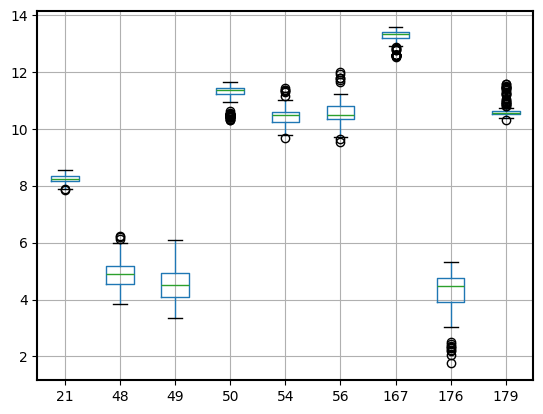

In [53]:
# to see multiple columns as a boxplot
#replace xxx and yyy with the specific amino acid numbers. You can add more names by adding commas.
df = pkatraj.results.pkas[[21, 48, 49, 50, 54, 56, 167, 176, 179]]
# select a range of columns by column number, change the 0 and 78 to the range of column numbers remember to remove the '#'
#df = pkatraj.results.pkas.iloc[:,0:78]

# results will be in the form of a boxplot
df.boxplot()

# Congrats, you have finished Step 2 of the MD Colab! :-)

## **Don't forget to download the files in your outputs folder!!!**


# Removing solvent from the trajectory

## Run this first code if you need to remove water from your files! If you already ran the above code, then don't run this unless told to.

Trajectory is a dynamic view of various properties in your protein, including atom coordinates, box size, velocities, and forces. Trajectory files looks at these variables as they change throughout time. We really only care about the protein in these simulations so we need to remove the waters and ions from the trajectory. This will greatly reduce the file size and the complexity.

First we will load the trajectory (.dcd) and the parameters for where the atoms are and the bonds (.prmtop). We will then remove the solvent and save the trajectory without solvent. We will also save a .pdb file of the first frame to help resolve case issues later on with amino acid numbering or where the system started. It is possible to extract any of the structures along the trajectory if needed.

---

All you need to edit is the first box of code, where you will need to change the file names. Otherwise, no edits are necessary and you can press PLAY.

In [ ]:
# load the trajectories (you will need to change the file names)
t = md.load('data/1aki_prod1_nw.dcd', top = 'data/SYS_nw.prmtop')

In [ ]:
# remove the waters and ions to make the analysis simpler
t2 = t.remove_solvent()

In [ ]:
# check the size of the trajectory before and after solvent, atom number in t2 < t if remove solvent worked
print(t)
print(t2)

In [ ]:
# save the no solvent trajectory and the first pdb file, we may save other structures in the trajectory later
t2.save_dcd("outputs/traj_no_solvent.dcd")
# python starts with 0 as the first number
t2[0].save_pdb("outputs/pdb_first.pdb")

In [ ]:
# If you need a different frame based on later analysis:
# 1) change the zero to the frame number
# 2) change the xxx in the file name to the frame number
# 3) remove the '#' in front of the command below and run the cell
# t2[XXX].save_pdb("outputs/pdb_xxx.pdb")


At this point, you have three different trajectory files that you need to compare. You could copy the loading and processing cells above to bring in the other files OR process each individually and make a new colab for comparing the 3 trajectories. For simplicity, I suggest processing the trajectories individually, however if you do decide to process them all here, then remember that you cannot use t or t2 as variable names.
